The purpose of this notebook is to explore the question **is it valid to use a chi-square random variable to compare group event proportions?**

Comparing group event proportions is commonly done in biostatistics to measure whether a treatment results in a particular outcome (an event), or not. This is traditionally done via a contingency table, where a test statstic is calculated by comparing the "observed" and "expected" event counts to each other. 

But is this method valid? And what is the relationship between chi-square distributed random variables, and binomial random variables in this situation? 

I performed this analysis mainly to gain greater confidence in the contingency table method. 

In [259]:
import numpy as np

from scipy.stats import binom
from scipy.stats.contingency import expected_freq
from scipy.stats import chi2_contingency
from scipy.stats import chisquare, chi2

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
FIG_SIZE = (15,5)

In [272]:
# setup seed so same results occur every time
np.random.seed(seed=42)

# Prove that when you take a normally distributed random variable and square it, you get a chi-square distributed random variable. 

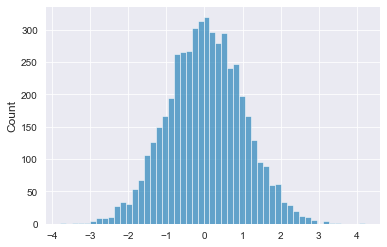

In [260]:
# take a normal random variable, sample it n times, and plot the distribution
from scipy.stats import norm
norm_rv = norm(loc=0, scale=1)
sample = norm_rv.rvs(5000)
sns.histplot(sample);

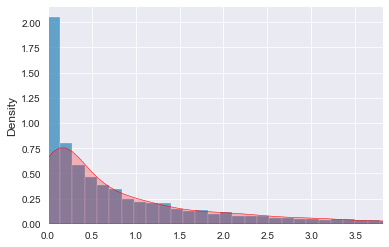

In [264]:
# square the sample
sample_squared = np.power(sample, 2)

# take a sample from a chi-squared distributed random variable
chisq_sample = chi2(df=1).rvs(5000) # use 1 degree of freedom

# plot the distribution
plt.figure()
ax = plt.gca()
ax.grid(zorder=0)
sns.histplot(sample_squared, ax=ax, stat='density', zorder=1);
sns.kdeplot(chisq_sample, ax=ax, color='r', fill=True, zorder=2);
plt.xlim(0, np.percentile(sample_squared, 95));

Typically, a binomial random variable can be approximated by a normal random variable, under the assumption that `n*p*q > 5` where n = number of samples, p = proportion, and q = 1 - p. 

# demonstrate via example that the method for calculating the test statistic and associated p-value using the contingency table method is valid (for a 2x2 table)

In [172]:
def calculate_chisq(p1, p2):
    '''
    args:
        p1 {float} -- proportion of events in group 1
        p2 {float} -- proportion of events in group 2
        
    returns:
        chisq {float} -- test statistic
    
    '''

    # sample size for each binomial random variable
    n1 = 100
    n2 = 100
    
    # setup 2 binomial random variables (rv1, rv2) that represent the true population proportions
    rv1 = binom(n=n1, p=p1)
    rv2 = binom(n=n2, p=p2)

    # take a sample from each rv
    x1 = rv1.rvs()
    x2 = rv2.rvs()

    # calculate observed values using margin totals and sampled values x1 and x2
    obs = np.array([[x1, n1 - x1], [x2, n2 - x2]])
    
    # calculate expected values
    exp = expected_freq(observed=obs)

    # calculate degrees of freedom
    ddof = (np.shape(obs)[0]-1) * (np.shape(obs)[1]-1)

    # compute chi-squared test statistic 
    terms = (obs.astype(np.float64) - exp)**2 / exp # don't apply continuity correction
    chisq = terms.flatten().sum()
    
    return chisq

Let's plot the distribution of test statistic values when the group proportions are equal to each other. 

In [85]:
# first set up arguments 
p1 = 0.5
p2 = 0.5

In [101]:
# setup number of samples we'll be taking
n_samples = 5000

In [173]:
# setup array to store sampled chi-square test statistics
_chisq = [calculate_chisq(p1, p2) for _ in range(n_samples)]

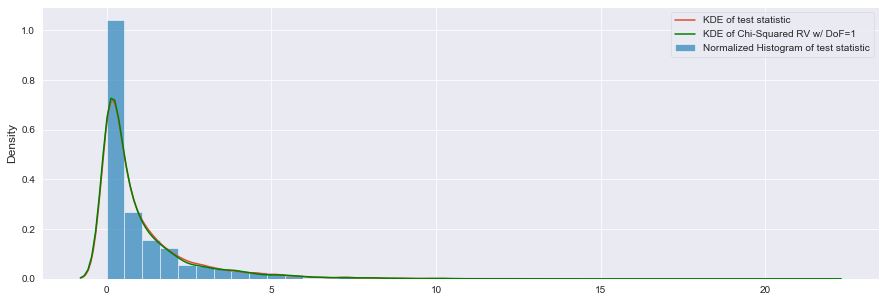

In [150]:
plt.figure(figsize=FIG_SIZE)
ax = plt.gca()
ax.grid(zorder=0)

sns.histplot(_chisq, bins=25, ax=ax, stat='density', zorder=1, label='Normalized Histogram of test statistic');
sns.kdeplot(_chisq, fill=False, ax=ax, zorder=2, label='KDE of test statistic');

chisq_sample = chi2(df=1).rvs(n_samples) # take a sample from a chi-squared distributed random variable, df = 1
sns.kdeplot(chisq_sample, fill=False, ax=ax, zorder=3, color='g', label='KDE of Chi-Squared RV w/ DoF=1');

plt.legend()

As we can see, there is close agreement between KDE of the distribution of the test statistic for our population with equal group event proportions (`p1 = p2 = 0.5`) *and* the KDE of `scipy`'s `chi2` random variable with degrees of freedom = 1. 

What happens if we move the individual group event proportions further and further away from each other?

So we'll keep `p1` equal to 0.5, but gradually move `p2` further and further from 0.5, plotting the KDE of the distribution of test statistics for each pair of values `p1` and `p2`.

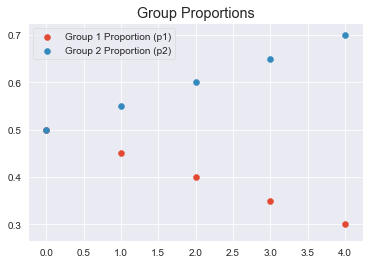

In [273]:
_p2 = np.round(np.linspace(start = 0.5, stop = 0.7, num = 5), decimals=2)
_p1 = np.round(np.linspace(start = 0.5, stop = 0.3, num = 5), decimals=2)

plt.scatter(x=range(len(_p1)), y=_p1, label='Group 1 Proportion (p1)');
plt.scatter(x=range(len(_p2)), y=_p2, label='Group 2 Proportion (p2)');
plt.title('Group Proportions');
plt.legend();

We'll plot the KDE of the distribution of the resulting test statistic for each pair of group event proportions `p1` and `p2`, as well as a reference plot of the KDE of a chi-squared random variable with degrees of freedom = 1.

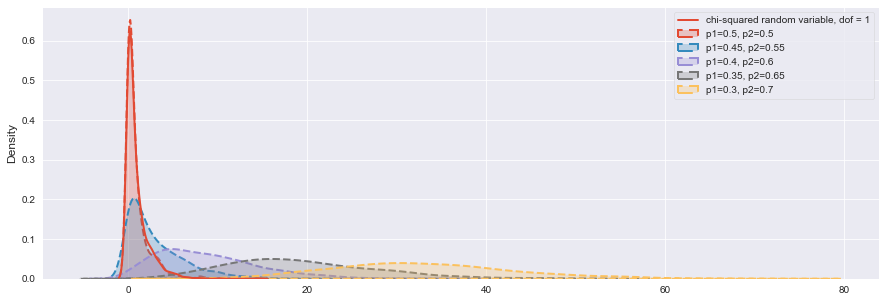

In [274]:
fig = plt.figure(figsize=FIG_SIZE)
ax = plt.gca()
for p1, p2 in zip(_p1, _p2):
    _chisq = [calculate_chisq(p1, p2) for _ in range(1000)] # take 1000 samples
    sns.kdeplot(_chisq, label=f'p1={p1}, p2={p2}', ax=ax, zorder=1, ls='--', lw=2.0, shade=True)
    
# For reference, plot the KDE of the chi-squared random variable with degrees of freedom = 1
sns.kdeplot(chi2(df=1).rvs(1000), label='chi-squared random variable, dof = 1', ax=ax, ls='-', lw=2.0, zorder=2) # take 1000 samples

plt.legend();

Notice how the KDE of the chi-squared random variable with 1 degree of freedom overlaps almost exactly with the KDE of the distribution of test statistics when `p1 = 0.5` and `p2 = 0.5`.

Interestingly, the distribution of the test statistic moves further away from our reference distribution the greater the distance  `p1` and `p2` are from each other. In other words, the greater the distance between the proportions `p1` and `p2`, the more likely a sample's test statistic is to be higher in value. 

But, what's the relevance of all this to hypothesis testing (and coming to conclusions based on a set of data)?

Well, if our null hypothesis $H_o$ is that there is **no** difference in the group event proportions (`p1 = p2`), and our alternative hypothesis $H_a$ is that there *is* a difference (`p1 != p2`), then we can:
1. setup a null condition using a chi-squared random variable with degrees of freedom 1
2. calculate the test statistic using our observed group event proportions $\hat{p_1}$ and $\hat{p_2}$
3. compare the test statistic calculated in step 2 with the distribution generated for the null condition in step 1. 

Let's do this with an example using differing population proportions.

step 1 is to generate a chi-squared random variable with DoF = 1.

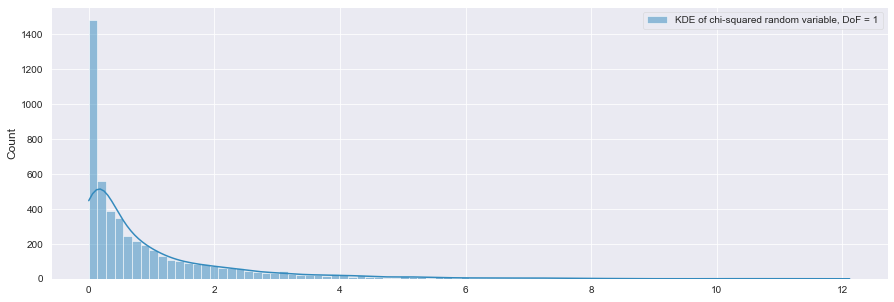

In [275]:
# create random variable
rv = chi2(df=1)

# take n samples
sample = rv.rvs(5000) 

# plot
plt.figure(figsize=FIG_SIZE)
ax = plt.gca()
sns.histplot(sample, kde=True, label='KDE of chi-squared random variable, DoF = 1', ax=ax);
plt.legend();

Now, for step 2, we'll set up population proportions and take a sample, and calculate the resulting test statistic (which we know from the previous explanation is distributed approximately the same as a chi-squared random variable).

In [281]:
# setup example population proportions
p1 = 0.5
p2 = 0.7

# sample from the population and calculate a test statistic
test_stat = round(calculate_chisq(p1, p2), 2)
print(test_stat)

3.26


Now let's plot where the P.D.F. of the distribution under $H_o$ (a chi-square random variable with DoF = 1), along with the test statistic, so we can compare the two. 

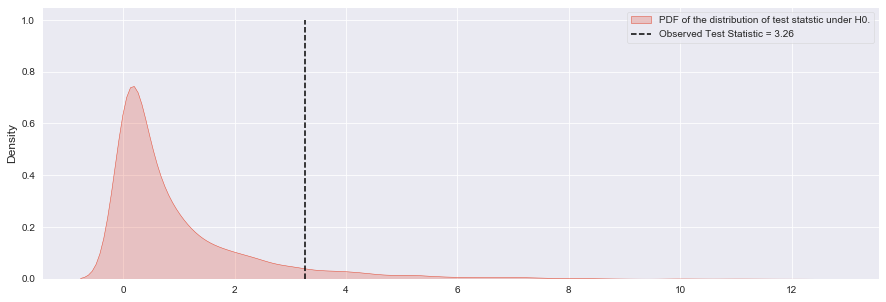

In [282]:
plt.figure(figsize=FIG_SIZE)
sns.kdeplot(sample, fill=True, label='PDF of the distribution of test statstic under H0.');
plt.vlines(x=test_stat, ymin=0, ymax=1.0, ls='--', label=f'Observed Test Statistic = {test_stat}')
plt.legend();

The observed test statistic is somewhat along the tail of the P.D.F. What we want to know is, is our observed test statistic an outlier, or is it within reasonable range of value given that the null hypothesis $H_o$ is True? I.e. Whats the likelihood we sampled the value we did, given that the null hypothesis is True? 

Of course, the p-value is the quantification of this likelihood. 

And we can calculate the p-value (the area under the curve to the right of the observed test statistic) using the C.D.F. of the chi-squared random variable. 

In [283]:
pvalue = 1 - rv.cdf(test_stat) # the CDF calculates the area to the left of the input value

In [284]:
print(pvalue)

0.07098912639916377


The pvalue tells us that, if the null hypothesis is true, we would expect to see test statistics with a value of at least the one we got about ~7% of the time. 

Using a standard cutoff for the significance level of $\alpha$ = 0.05, we would not consider this result as significant, and we would fail to reject the null. 

So despite the actual population proportions being quite different (`p1=0.5` vs `p2=0.7`), based on the sample we drew, we cannot conclude that there is a significant difference in the outcomes of the two populations.